<a href="https://colab.research.google.com/github/nhuang37/spectral-inspired-gnn/blob/main/power_dense_sparse_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import os
import numpy as np
from numpy import linalg as LA
import numpy.random as npr
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from scipy.sparse.linalg import eigsh, eigs
from scipy.linalg import hadamard, subspace_angles
import itertools

### Common helper functions

In [2]:
def get_angle(x,y, sign=False):
  '''
  compute angle between vectors x and y
  '''
  x = x / LA.norm(x)
  y = y / LA.norm(y)
  with np.errstate(divide='ignore',invalid='ignore'):
    rad = np.arccos(np.clip(np.dot(x,y), -1, 1))
  angle = np.min((np.degrees(rad), 360-np.degrees(rad)))
  if sign: #care about the direction, [0,180]
    return angle
  else: #modulo sign, [0,90]
    return np.min((angle, 180-angle))

def compute_pairs(emb_gnn, ASE):
  '''
  compute pairwise angles of GNN embedding and ASEs
  '''
  k = emb_gnn.shape[1]
  angles = []
  #combs = itertools.combinations(range(k), 2)
  #for (i,j) in combs:
  for i in range(emb_gnn.shape[1]):
    min_angle = np.zeros(ASE.shape[1])
    for j in range(ASE.shape[1]):
      min_angle[j] = get_angle(emb_gnn[:,i], ASE[:,j])
    angles.append(min_angle.min())
  return np.array(angles)

In [3]:
def power_iterate(g, feat, K, rw=False, include_feat=True, upper_tri=False):
    """
    Precompute power-iterated features
    g: graph, numpy array (n by n)
    feat: features
    Return: a list with length-K of feature matrices, each with shape (n by d)
    If rw: use D^{-1}A instead of A as the graph operators
    """
    if include_feat:
      powers = [feat]
    else:
      powers = []
    if rw:
      Dinv = 1 / g.sum(axis=1) 
      g = g * Dinv[:, None] 
    for iter in range(K):
      #message passing
      tildeU = g @ feat 
      #normalization
      if upper_tri:
        normalizer = np.linalg.pinv(np.triu(tildeU.T @ tildeU))
      else:
        normalizer = np.linalg.pinv(tildeU.T @ tildeU)
      feat = tildeU @ normalizer #scaled eigenvector (arbitrary rotated if upper_tri is False)
      col_norm = np.linalg.norm(feat, axis=0)
      powers.append(feat / col_norm)
    return powers

In [4]:
def construct_2BSBM(n, p, q, seed=0):
  '''
  Generate a random (n)-nodes symmetric 2-block SBM
  '''
  assert n % 2 == 0, "must pass in even number of nodes"
  probs = [[p,q],[q,p]]
  nvecs = [n//2, n//2]
  graph = nx.stochastic_block_model(nvecs, probs, seed=seed)
  return nx.to_numpy_array(graph)

def construct_graph(n, nvecs, p_d, q_d, p_s, q_s, a, b, seed=0):
  '''
  Generate a random (n)-nodes 4-block symmetric SBM using probability matrix prob 
  n: total number of nodes
  nvecs: number of nodes per block
  p_d, q_d: dense block connectivity probability
  p_s, q_s: sparse block connectivity probability
  a, b: cross edges
  probability matrix B:
    [[p_d, q_d, a, b],[q_d, p_d, b, a],[a, b, p_s, q_s], [b, a, q_s, p_s]]
  return DGL_graph; numpy adjacency matrix
  '''
  assert n % 4 == 0, "must pass in node numbers that can be divided by 4 (4-block symmetric SBM!)"
  #sizes = [n//4, n//4, n//4, n//4]
  probs = [[p_d, q_d, a, b],[q_d, p_d, b, a],[a, b, p_s, q_s], [b, a, q_s, p_s]]
  graph = nx.stochastic_block_model(nvecs, probs, seed=seed)
  return nx.to_numpy_array(graph)

def gaussian_features(n, in_feats, cov_scale, mean_scale=1, seed=0):
  '''
  n: number of nodes per block
  in_feats: input feature dimension
  cov_scale: scaling factor for covariance matrix
  return (2n x in_feats) feature matrix, where the first n rows are sample iid from N([1,...1], cov_scale*I), 
  the last n rows are sample iid from N([-1,...-1], cov_scale*I)
  '''
  np.random.seed(seed)
  mean = mean_scale*np.ones(in_feats)
  cov = cov_scale*np.eye(in_feats)
  feat_1 = np.random.multivariate_normal(mean, cov, n//2)
  feat_2 = np.random.multivariate_normal(-mean, cov, n//2)
  features = np.concatenate((feat_1, feat_2), axis=0)
  return features


In [5]:
def feature_classify(features, Ys, train_mask):
  '''
  features: node features
  Ys: classification label
  train_mask: mask for trainingset
  return: test_acc, Yhats (entry = train labels if available)
  '''
  #clf = svm.SVC(kernel='linear', max_iter=500)
  K = min(len(np.unique(Ys))-1, features.shape[1])
  clf = LinearDiscriminantAnalysis(n_components=K)
  clf.fit(features[train_mask], Ys[train_mask])
  Yhats = clf.predict(features)
  Yhats[train_mask] = Ys[train_mask]
  return clf.score(features[~train_mask], Ys[~train_mask]), len(Ys[~train_mask]), Yhats

In [6]:
def emb_ASE(A, k=2):
  '''
  ASE embedding
  '''
  # u, s, v = np.linalg.svd(A, hermitian=True)
  # return u[:, :k] * s[:k]
  evalues, evectors = eigsh(A, k=k)
  return evectors[:, :k]

def emb_covX(Xouter, k=2):
  '''
  top-k eigenvector of covariance
  '''
  evaluesX, evectorsX = eigsh(Xouter, k=k)
  return evectorsX[:, :k]

def emb_SGC(A, feats, k=2, n_layer=1):
  '''
  SGC embedding using identity (node identifier) as initial feature
  A: with self-loop
  '''
  Dinv = 1 / A.sum(axis=1) 
  A_rw = A * Dinv[:, None] 
  out = feats
  for layer in range(n_layer):
    out = A_rw @ feats
  return out



### PowerEmbed simulation

In [7]:
def test_power_iter(n, p, q, K, k=2, self_loop=True, runs=30, upper_tri=False):
  results = []
  for run in range(runs):
    g = construct_2BSBM(n, p, q, seed=run)
    #evalues, evectors = eigsh(g, k=k) #arbitrarily ordered
    u, s, vh = np.linalg.svd(g, hermitian=True)
    if self_loop:
      g = g + np.eye(n)
    X = np.random.rand(n,k)
    powers = power_iterate(g, X, K, include_feat=False, upper_tri=upper_tri)
    angles = np.zeros((K,k))
    for t, u_est in enumerate(powers):
      if upper_tri:
        angles[t,0] = get_angle(u_est[:,0], u[:,0])
        angles[t,1] = get_angle(u_est[:,1], u[:,1])
      else:
        angles[t,:] =  np.rad2deg(subspace_angles(u_est, u[:,:2]))
      results.append(angles)
  return np.array(results)

def convergence_rate(evalue, K=2):
  ratios = []
  for k in range(K):
    ratios.append((evalue[:,k+1]/evalue[:,k]).mean())
  return ratios

In [8]:
%%time
K = 50
n = 500
test_power_runs_dense = test_power_iter(n=n, p=1/2, q=1/3, K=K)
test_power_runs_med = test_power_iter(n=n, p=1/10, q=1/15, K=K)
test_power_runs_sparse = test_power_iter(n=n, p=1/20, q=1/30, K=K)

CPU times: user 23.9 s, sys: 28.8 s, total: 52.7 s
Wall time: 18.7 s


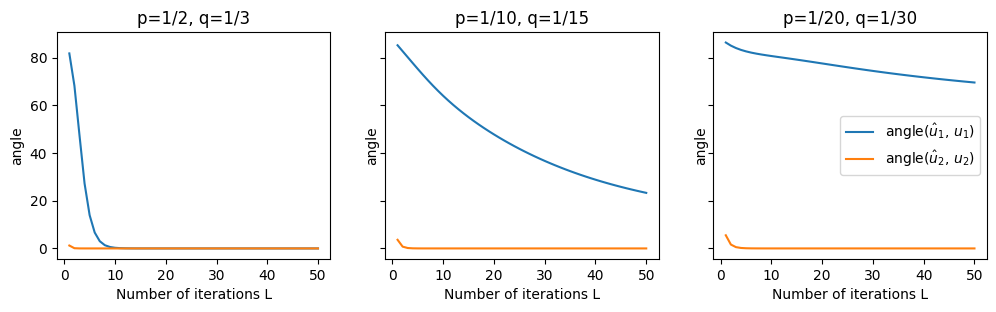

In [9]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,3), dpi=100)
mean_dense = test_power_runs_dense.mean(axis=0)
mean_med = test_power_runs_med.mean(axis=0)
mean_sp = test_power_runs_sparse.mean(axis=0)
for i, mean in enumerate([mean_dense, mean_med, mean_sp]):
  axs[i].plot(np.arange(1,K+1), mean[:,0], label=r'angle($\hat{u}_1$, $u_1$)')
  axs[i].plot(np.arange(1,K+1), mean[:,1], label=r'angle($\hat{u}_2$, $u_2$)')
  axs[i].set_xlabel("Number of iterations L")
  axs[i].set_ylabel("angle")

axs[0].set_title(r'p=1/2, q=1/3')
axs[1].set_title(r'p=1/10, q=1/15')
axs[2].set_title(r'p=1/20, q=1/30')
plt.legend()
plt.show()

In [10]:
def run_simulation(n, p, q, graph_seeds=30, k=2):

  torch.manual_seed(0)

  train_pct = 0.1
  train_mask = torch.FloatTensor(n).uniform_() > (1-train_pct)#torch.cuda.FloatTensor(n).uniform_() > (1-train_pct) #torch.ByteTensor(2*n)
  features = gaussian_features(n, in_feats=2, cov_scale=4)
  Ys = np.array([1]*(n//2) + [-1]*(n//2))
  results = {'ASE':[], 'Cov(X)':[], 'A_X':[]}
  Ks = np.arange(1,11)
  for K in Ks:
    results['Power_'+str(K)] = []

  for run in range(graph_seeds):
    A = construct_2BSBM(n, p, q, seed=run)
    features = gaussian_features(n, in_feats=2, cov_scale=4, seed=run)
    train_mask_all = (torch.FloatTensor(n).uniform_() > (1-train_pct)).numpy()
    #vanilla ASE on the whole graph
    ASE_feat = emb_ASE(A, k=k)
    #cov
    Xouter = features @ features.T
    cov_feat = emb_covX(Xouter, k=k)
    #A_X
    A_X_feat = np.concatenate((ASE_feat, cov_feat), axis=1)
    for name, emb in zip(['ASE', 'Cov(X)', 'A_X'], [ASE_feat, cov_feat, A_X_feat]):
      acc, _, _ = feature_classify(emb, Ys, train_mask_all)
      results[name].append(acc)    
    #powers
    powers = power_iterate(A, features, K=10, include_feat=False )
    for K in Ks:
      power_emb = np.concatenate(powers[:(K+1)], axis=1)
      acc_power, _, _ = feature_classify(power_emb, Ys, train_mask_all)
      results['Power_'+str(K)].append(acc_power)
  
  return results

In [11]:
%%time
#teresa's simulation: test subspace iteration for GNNs - dense
n = 500
p = 1/2 
q = 1/3 
graph_seeds = 30
results = run_simulation(n, p, q, graph_seeds)
p_s = 1/20
q_s = 1/30
results_sp = run_simulation(n, p_s, q_s, graph_seeds)

CPU times: user 13.4 s, sys: 18.1 s, total: 31.5 s
Wall time: 9.38 s


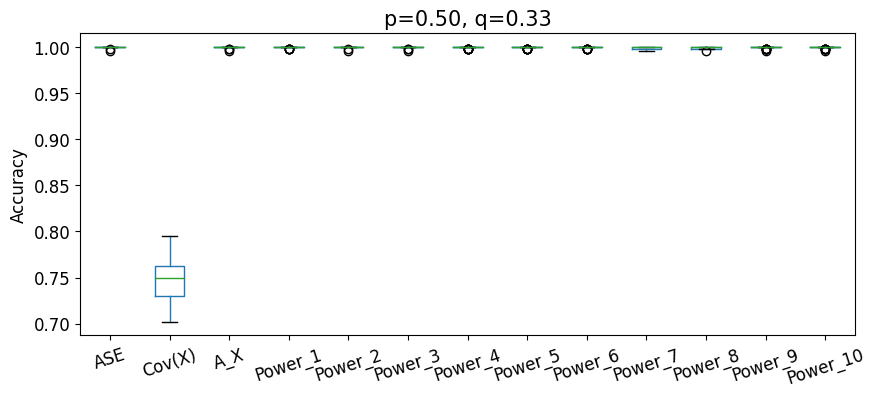

In [12]:

import pandas as pd
plt.figure(figsize=(10, 4), dpi=100)
df = pd.DataFrame.from_dict(results)
df.boxplot(grid=False, rot=18, fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f"p={p:.2f}, q={q:.2f}", fontsize=15) # n={n}, train_pct=0.1, MC_runs={graph_seeds}
plt.show()

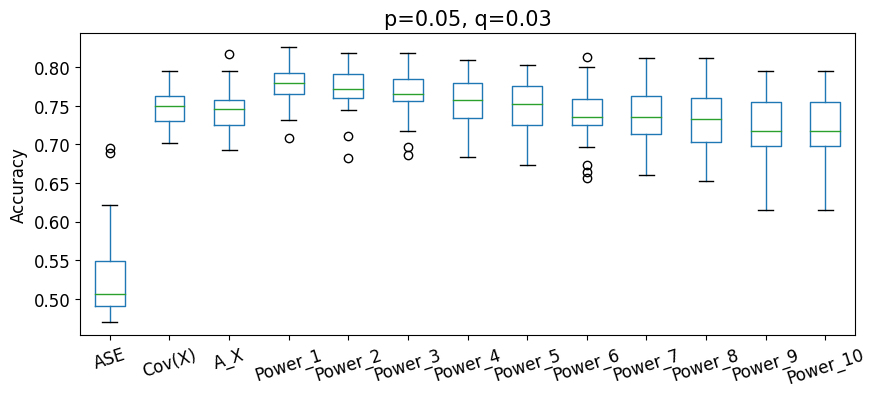

In [13]:
plt.figure(figsize=(10, 4), dpi=100)
df = pd.DataFrame.from_dict(results_sp)
df.boxplot(grid=False, rot=18, fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f"p={p_s:.2f}, q={q_s:.2f}", fontsize=15)
plt.show()

### Graph decomposition simulation

In [14]:

def kcore_classify(A, nvecs, Ys, train_mask, oracle=True, kc=None, k=2, verbose=False, power=False, feat=None):
  '''
  Graph = dense + sparse
  1. Obtain kcore (dense) part of the graph, run emb_ASE + classify => obtain Yhats for dense nodes
  2. Perform majority vote (type) label propogation for sparse node => obtain Yhats for sparse ndoes
  - 2.1 Use majority mean from dense nodes as features for sparse nodes + classify
  '''
  n = A.shape[0]
  if oracle: #4b-sbm, return the first two blocks
    dense_num = nvecs[0] + nvecs[1]
    A_dense = A[:dense_num, :dense_num] #A[:n//2, :n//2]
    dense_IDs = np.array([True] * dense_num + [False] * (n - dense_num)) #mask out dense nodes - always a boolean array because we want to use ~dense_IDs to select sparse nodes!
    if power:
      assert feat is not None, "must pass in node feature if using PowerEmbed"
      powers = power_iterate(A_dense, feat[:dense_num, :], K=2)
      feat_dense = np.concatenate(powers, axis=1)
    else:
      feat_dense = emb_ASE(A_dense, k=k)

  else: 
    assert kc is not None, "must specify the minimum node degree for kcore"
    nx_graph = nx.from_numpy_array(A)
    graph_dense = nx.k_core(nx_graph, k=kc)
    dense_nodes = list(graph_dense.nodes())
    dense_IDs = np.array([False] * n)
    dense_IDs[dense_nodes] = True
    if verbose:
      print(f"kcore graph size = {np.sum(dense_IDs)}")
    A_dense = nx.to_numpy_array(graph_dense)
    if power:
      assert feat is not None, "must pass in node feature if using PowerEmbed"
      powers = power_iterate(A_dense, feat[dense_IDs,:], K=2 )
      feat_dense = np.concatenate(powers, axis=1)
    else:
      feat_dense = emb_ASE(A_dense, k=k)

  #dense classify
  train_mask_dense = train_mask[dense_IDs]
  test_acc_dense, num_dense_test, Yhats_dense = feature_classify(feat_dense, Ys[dense_IDs], train_mask_dense)
  #sparse classify
  train_mask_sparse = train_mask[~dense_IDs]
  test_mask_sparse = ~train_mask[~dense_IDs]
  #message-passing
  num_dense_neighbors = A[np.ix_(~dense_IDs,dense_IDs)].sum(axis=1)
  num_dense_neighbors[num_dense_neighbors == 0] = -1
  message_fromDense = A[np.ix_(~dense_IDs,dense_IDs)] @ Yhats_dense / num_dense_neighbors
  #label prop:
  Yhats_sp = message_fromDense > 0
  Yhats_sp = Yhats_sp.astype(int)
  Yhats_sp[Yhats_sp == 0] = -1
  test_acc_sp = np.sum((Yhats_sp[test_mask_sparse] == Ys[~dense_IDs][test_mask_sparse]))
  num_sparse_test = len(Yhats_sp[test_mask_sparse])
  if verbose:
    print(f"dense acc = {test_acc_dense:.2f}, num_dense_test = {num_dense_test}, sparse acc = {(test_acc_sp/num_sparse_test):.2f}, num_sparse_test = {num_sparse_test}")
  test_acc = (test_acc_dense * num_dense_test + test_acc_sp)/(len(Ys[~train_mask]))
  #label as features:
  test_acc_sp_feat, num_sparse_test, _ = feature_classify(message_fromDense.reshape(-1,1), Ys[~dense_IDs], train_mask_sparse )
  test_acc_feat = (test_acc_dense * num_dense_test + test_acc_sp_feat * num_sparse_test)/(len(Ys[~train_mask]))
  return test_acc, test_acc_feat

In [15]:
def MC_run(n, nvecs, p_d, q_d, p_s, q_s, a, b, k=2, num_runs=30, oracle=True, kc=20, verbose=False):
  '''
  nvecs = [size_1, size_2, size_3, size_4], must sum to n
  '''
  #train mask
  torch.manual_seed(0)
  train_pct = 0.5
  Ys = np.array([1]*nvecs[0] + [-1]*nvecs[1] + [1]*nvecs[2] + [-1]*nvecs[3])
  #MC run
  results = {'ASE':[], 'Cov(X)':[], 'A_X':[], 'MP-1':[], 'MP-2':[], 'decomp(ASE)':[], 'decomp(Power)':[]}
  for run in range(num_runs):
    A = construct_graph(n, nvecs, p_d, q_d, p_s, q_s, a, b, seed=run)
    features = gaussian_features(n, in_feats=2, cov_scale=4, seed=run)
    train_mask_all = (torch.FloatTensor(n).uniform_() > (1-train_pct)).numpy()
    #vanilla ASE on the whole graph
    ASE_feat = emb_ASE(A, k=k)
    #cov
    Xouter = features @ features.T
    cov_feat = emb_covX(Xouter, k=k)
    #A_X
    A_X_feat = np.concatenate((ASE_feat, cov_feat), axis=1)
    #vanilla SGC on the whole graph
    SGC_1 = emb_SGC(A, features, k=k, n_layer=1)
    SGC_2 = emb_SGC(A, features, k=k, n_layer=2)
    
    for name, emb in zip(['ASE', 'Cov(X)', 'A_X','MP-1','MP-2'],
                         [ASE_feat, cov_feat, A_X_feat, SGC_1, SGC_2]):
      acc, _, _ = feature_classify(emb, Ys, train_mask_all)
      results[name].append(acc)    
    #graph decomp
    decomp_acc, _ = kcore_classify(A, nvecs, Ys, train_mask_all, oracle=oracle, kc=kc, k=k, verbose=verbose)
    results['decomp(ASE)'].append(decomp_acc)
    decomp_acc_pow, _ = kcore_classify(A, nvecs, Ys, train_mask_all, oracle=oracle, kc=kc, k=k, verbose=verbose,
                                       power=True, feat=features)
    results['decomp(Power)'].append(decomp_acc_pow)
  return results

In [16]:
import pandas as pd 
def plot_result(results_all, n, nvecs, p_d, q_d, p_s, q_s):
  fig, axs = plt.subplots(ncols=2,figsize=(10,3), sharey=True, dpi=150)

  for i, (key, results) in enumerate(results_all.items()):
    df = pd.DataFrame.from_dict(results)
    df.boxplot(grid=False, rot=18, fontsize=12, ax=axs[i])
    axs[i].set_ylabel('Accuracy')
    a, b = key
    axs[i].set_title(f"a={a:.3f}, b={b:.3f}")

  #fig.suptitle(f"4-block 2-class symmetric SBM, n={n}, p={p_d:.2f}, q={q_d:.2f}, p'={p_s:.3f}, q'={q_s:.3f}, MC_runs=20", fontsize=12, y=1.02)
  #fig.suptitle(f"sizes=({nvecs})", y=1.02)
  fig.tight_layout()
  plt.show()

In [17]:
n = 300
nvecs = [n//4, n//4, n//4, n//4]
#opt_a, opt_b, opt_pp, opt_qq = 2/n, 1/(2*n)
#trick: a, b must also be sparse in order for kcore to outperform ASE
configs = [(1/15, 1/30), (1/25, 1/50)] #(1/10, 1/20), 
p_d, q_d = 1/3, 1/4
p_s, q_s = 1/30, 1/40
results_all_34 = {}
#oracle setting: where we KNOW where the dense subgraph is!
for (a,b) in configs:
  results_all_34[(a,b)] = MC_run(n, nvecs, p_d, q_d, p_s, q_s, a, b, num_runs=30, oracle=True, verbose=False)

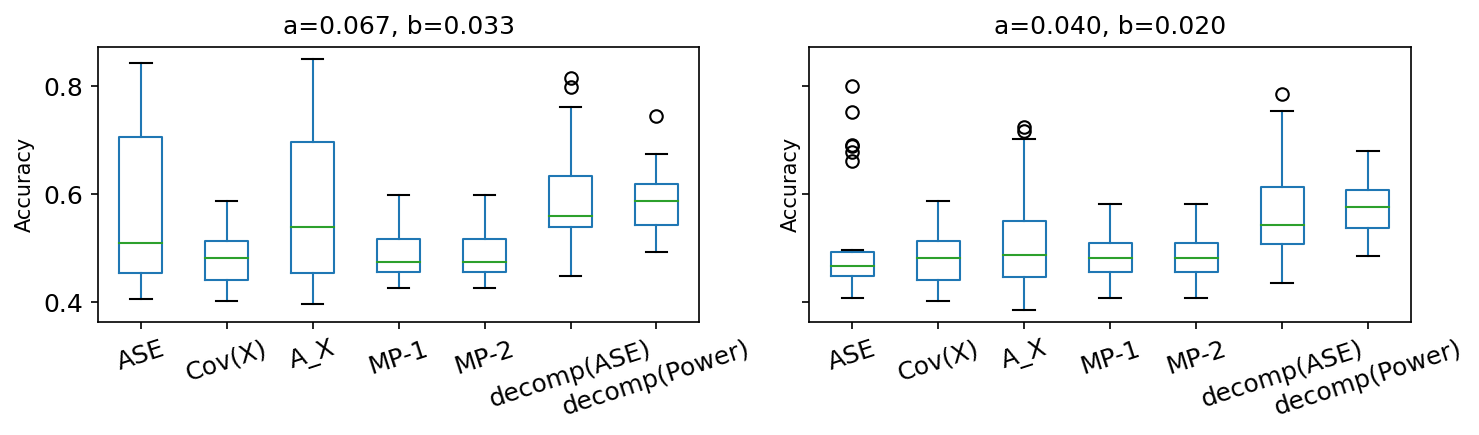

In [18]:
plot_result(results_all_34, n, nvecs, p_d, q_d, p_s, q_s)

In [21]:
#Practical setting: we do not know the dense subgraph, and need to estimate it from the actual graph using kcore subgraph
#estimated the threshold for kcore minimum degree: pretty robust (from kc=15 ~ 20 all work fine)
results_all_34_est_15 = {}
for (a,b) in configs:
  results_all_34_est_15[(a,b)] = MC_run(n, nvecs, p_d, q_d, p_s, q_s, a, b, num_runs=30, oracle=False, k=2, kc=15, verbose=False)

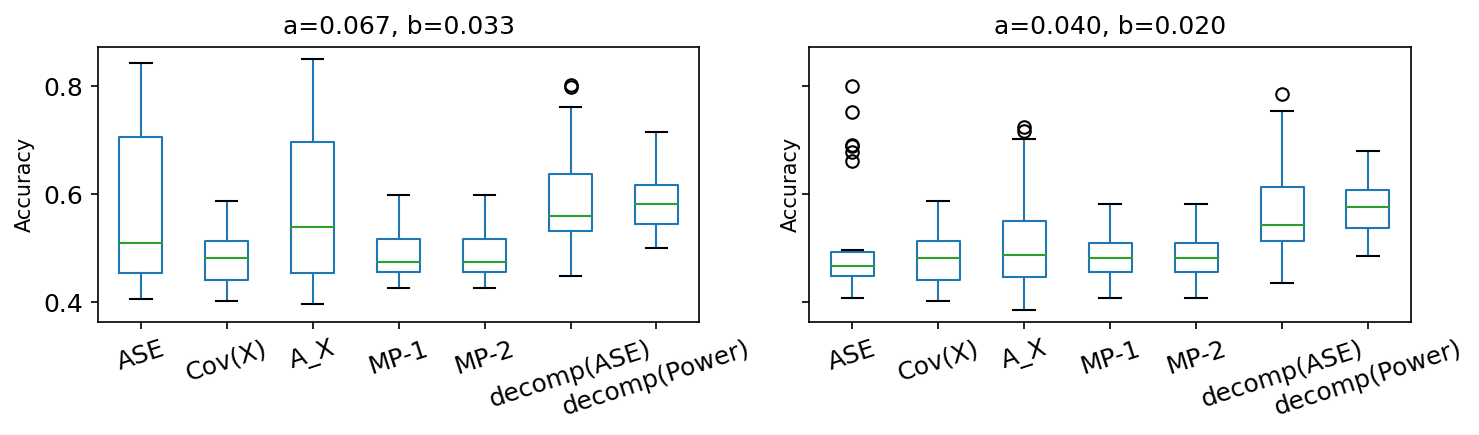

In [22]:
plot_result(results_all_34_est_15, n, nvecs, p_d, q_d, p_s, q_s)

In [23]:
results_all_34_est_20 = {}
for (a,b) in configs:
  results_all_34_est_20[(a,b)] = MC_run(n, nvecs, p_d, q_d, p_s, q_s, a, b, num_runs=30, oracle=False, k=2, kc=20, verbose=False)

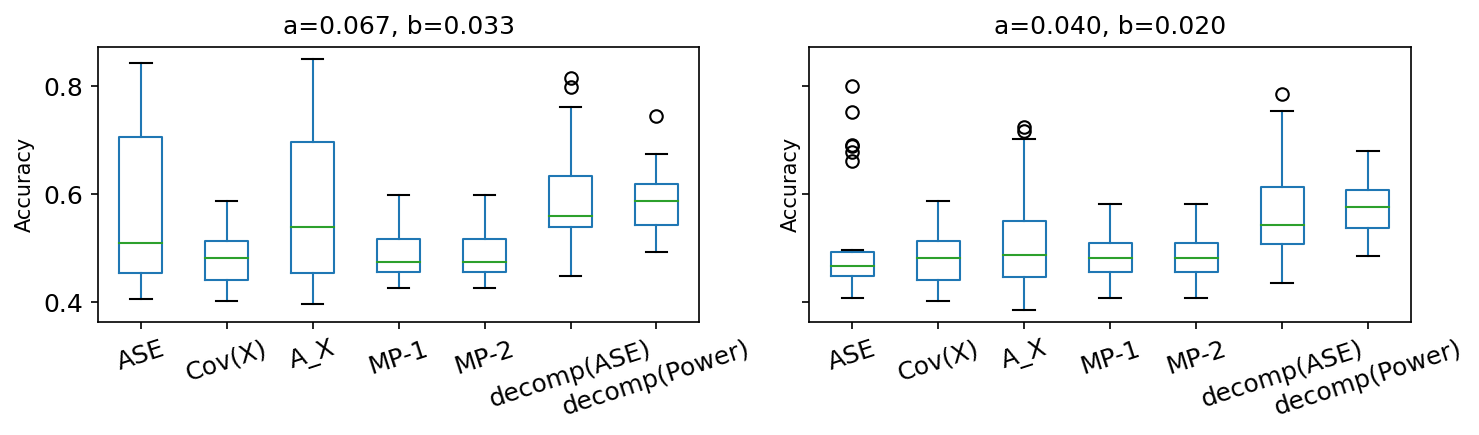

In [24]:
plot_result(results_all_34_est_20, n, nvecs, p_d, q_d, p_s, q_s)